In [82]:
from pymatgen.core import Structure
from pymatgen.core.trajectory import Trajectory
from pymatgen.io.vasp.outputs import Xdatcar,Vasprun
# from pymatgen_diffusion.neb.pathfinder import IDPPSolver
# from pymatgen_diffusion.aimd.pathway import ProbabilityDensityAnalysis
# from pymatgen_diffusion.aimd.van_hove import VanHoveAnalysis
from pymatgen.analysis.transition_state import NEBAnalysis, combine_neb_plots
from matplotlib import pyplot as plt
from pymatgen.analysis.diffusion_analyzer import DiffusionAnalyzer,get_arrhenius_plot
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize
import re
import seaborn as sns
import pandas as pd
import copy
import matplotlib.image as mpimg # mpimg 用于读取图片
from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
import matplotlib as mpl
from matplotlib.pyplot import MultipleLocator

In [83]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

config = {
    "font.family":'serif',
    "font.size": 20,
    "mathtext.fontset":'stix',
    "font.serif": ['Times New Roman'],
    "font.weight":'bold'
}
rcParams.update(config)
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 30}
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [84]:
elements = 'O'
tet_index ={'Cl':1,'Br':1,'I':1,'S':2,'O':2}
oct_index ={'Cl':2,'Br':2,'I':2,'S':1,'O':1}
volume_dict = {'S':46.81,'Cl':30.81,'O':25.28,'Br':41.89,'I':54.687}
xmin = {'S':20,'O':10,'Cl':10}
xmax = {'S':80,'O':40,'Cl':70}
marker_1 = {'Oct':'o','Tet':'v'}
anion_charge = {'Cl':[0.25,0.85],'Br':[0.25,0.85],'I':[0.25,0.85],'S':[0.5,1.7],'O':[0,1.7]}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]}
volume_list = [0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
volume_per_list = [round(i*volume_dict[elements],2) for i in volume_list]
ss_c = [-i for i in anion_charge_list[elements]] 
ss_v = volume_list
step = 4

In [85]:
results5 = pd.read_csv(f'./2022-07-11-fcc/fcc_Li{elements}_Ea.csv',header=None)
total_lens5 = results5.shape[0]/step

In [86]:
rlist5 = []
for i in range(0,int(total_lens5)):
    # print(i)
    t = results5.loc[i*step:i*step+step-1]
    t.columns = t.iloc[0]
    t = t.reset_index()
    t = t.drop(t.index[0])
    t['re_E'] = pd.to_numeric( t['re_E'])
    t['Energy'] = pd.to_numeric( t['Energy'])
    t['Force'] = pd.to_numeric( t['Force'])
#     print(t)
    rlist5.append(t)

In [87]:
data_list5 = []
for j in rlist5:
    data = {}
    title = j.columns[1].split('-')
    # print(j['re_E'].values[0])
    data['d'] = float(title[2])
    data['c'] = float(title[4])
    data['v'] = float(title[6])
    data['Etet-Eoct'] = float(j['re_E'].values[-1])-float(j['re_E'].values[0])
    data['Ea'] = j['re_E'].max()-j['re_E'].min()
    data['Etri'] = j['Energy'].values[1]
    data['Etet'] = j['Energy'].values[0]
    data['Eoct'] = j['Energy'].values[-1]
    data_list5.append(data)

In [88]:
r5 = pd.DataFrame(data_list5)

In [89]:
ss1 = [1,1.04,1.08,1.12,1.16,1.2]
ss2 =[3.710959e-29
,1.807483e-01
,7.160662e-01
,1.585847e+00
,2.758709e+00
,4.194799e+00]
ss3 = [2.651429e-12
,   1.292910e-01
,   5.143897e-01
,   1.147123e+00
,   2.014352e+00
,   3.098644e+00]
ss2 = [round(i,2) for i in ss2]
ss3 = [round(i,2) for i in ss3]
ss4 = volume_list
ss4_1 = [round(k*volume_dict[elements],2) for k in volume_list]

# ss_c.reverse()
marker_list = ['a','b','c','d','e','f','g'] 
ress_lists = []
index_2 = 1
for index_1 in [0,1,2,3,4,5]:
    ress_list1 = []
    for k in ss1[index_1:index_1+1]:
        for i in ss_c:
            data_l = []
            for j in ss_v:
                Ea_i = r5[(r5['c']==-i)&(r5['v']==j)&(r5['d']==k)].values[0][4]
                data_l.append(Ea_i)
            ress_list1.append(data_l)
    ress_lists.append(ress_list1)

df_Ea_list = []
# print(ress_lists[2])
for i in ress_lists:
    # print(i)
    df_Ea = pd.DataFrame(i,columns=ss4_1,index=ss_c)
#     df_tet_oct_norm = df_tet_oct.sub(df_tet_oct[ss1[0]], axis=0)
    df_Ea_list.append(df_Ea)


In [90]:
# r1 = pd.DataFrame(data_list)
# r2 = pd.DataFrame(data2_list)

# ss_list[elements]
# print(ss)
# [0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85] 
# [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,]
#       1.3,1.4,1.5,1.6,1.7]
#       1,1.1,1.2]
#       1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
ss1 = [1,1.04,1.08,1.12,1.16,1.2]
ss2 =[3.710959e-29
,1.807483e-01
,7.160662e-01
,1.585847e+00
,2.758709e+00
,4.194799e+00]
ss3 = [2.651429e-12
,   1.292910e-01
,   5.143897e-01
,   1.147123e+00
,   2.014352e+00
,   3.098644e+00]
ss2 = [round(i,2) for i in ss2]
ss3 = [round(i,2) for i in ss3]
ss4 = volume_list
ss4_1 = [round(k*volume_dict[elements],2) for k in volume_list]

# ss_c.reverse()
marker_list = ['a','b','c','d','e','f','g'] 
ress_lists = []
index_2 = 1
for index_1 in [0,1,2,3,4,5]:
    ress_list1 = []
    for k in ss1[index_1:index_1+1]:
        for i in ss_c:
            data_l = []
            for j in ss_v:
        #         print(i)
#         r1[(r1['c']==-i)&(r1['v']==j)&(r1['d']==k)].values[0][5]+
                Etet_Eoct_i = r5[(r5['c']==-i)&(r5['v']==j)&(r5['d']==k)].values[0][3]

                data_l.append(Etet_Eoct_i)
            ress_list1.append(data_l)
    ress_lists.append(ress_list1)

df_Etet_Eoct_list = []
# print(ress_lists[2])
for i in ress_lists:
    # print(i)
    df_Etet_Eoct = pd.DataFrame(i,columns=ss4_1,index=ss_c)
#     df_tet_oct_norm = df_tet_oct.sub(df_tet_oct[ss1[0]], axis=0)
    df_Etet_Eoct_list.append(df_Etet_Eoct)


[' CSM = 0.0', ' CSM = 0.18', ' CSM = 0.72', ' CSM = 1.59', ' CSM = 2.76', ' CSM = 4.19']


/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-v" (-> linestyle='-'). The keyword argument will take precedence.
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator


(10.0, 40.0, 0.0, 2.0)

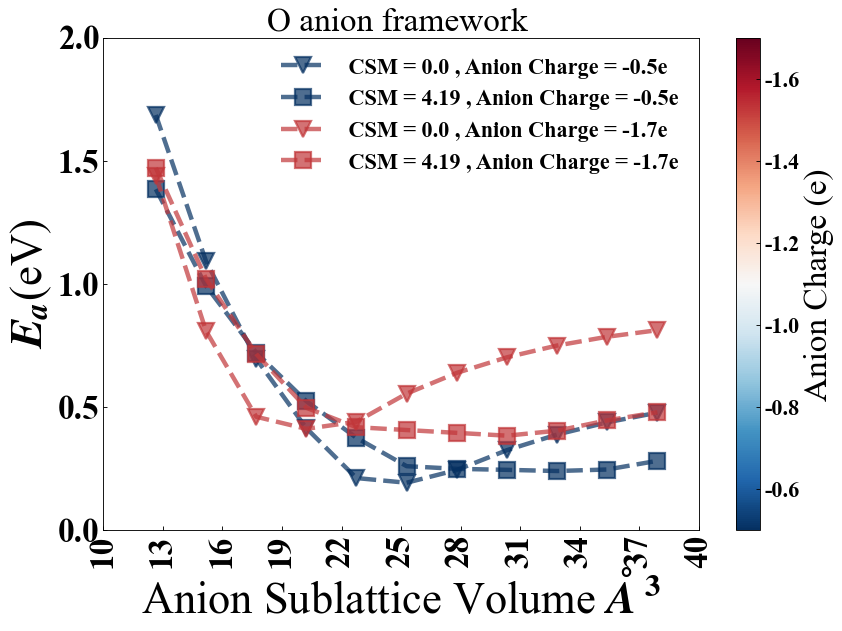

In [91]:
# xstick = volume_per_list
xt = anion_charge_list[elements]
xstick = [0.5,1.7]
type_1 = ''
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
plt.figure(figsize=(12,8),dpi=80)
# plt.xlim((-0.1,3))
# plt.ylim((-0.1,0.5))

a_plt = []
ymax = 0.5
ymin = -0.5
# marker_list =  ['-o', '-v', '-^', '-<','-p']
marker_list1 =  ['-o', '-v', '-^','-<','-p','-s',"->","-P","-*","-H","-+"]
num_plots = len(xt)+2
colormap = plt.cm.RdBu_r
# cmap = mpl.cm.cool
color_array = [colormap(i) for i in np.linspace(0, 1, num_plots)]
# cmap = mpl.cm.cool
# norm = mpl.colors.Normalize(vmin=5, vmax=10)
min, max = (-40, 30)
step = 20
mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['red','blue'])
# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
norm = mpl.colors.Normalize(vmin=xstick[0], vmax=xstick[-1])
# norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu_r)
# cmap.set_array([])
# plt.clf()

vol_list = [0,1,2,3]
a_plt = []
for k in xstick:
#     print(ss.index(k))
    # print(df_tet_oct1)
#     t_plt, = plt.plot(df_tet_oct_list[0].columns.tolist(),df_tet_oct_list[0].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[0]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
    t_plt1, = plt.plot(df_Ea_list[1].columns.tolist(),df_Ea_list[1].iloc[int(xt.index(k))].tolist(),f'{marker_list1[1]}',
                 c=color_array[xt.index(k)], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt2, = plt.plot(df_tet_oct_list[2].columns.tolist(),df_tet_oct_list[2].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[2]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt3, = plt.plot(df_tet_oct_list[3].columns.tolist(),df_tet_oct_list[3].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[3]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt4, = plt.plot(df_tet_oct_list[4].columns.tolist(),df_tet_oct_list[4].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[4]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
    t_plt5, = plt.plot(df_Ea_list[5].columns.tolist(),df_Ea_list[5].iloc[int(xt.index(k))].tolist(),f'{marker_list1[5]}',
                 c=color_array[xt.index(k)], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.7,linestyle="--",)
    a_plt.append(t_plt1)
    a_plt.append(t_plt5)
                  # markerfacecolor='none')
  # t_plt1,=plt.plot(df_oct_norm.columns.tolist(),df_oct_norm.iloc[int(xstick.index(k))].tolist(),'-o',c=color_array[xstick.index(k)], markersize=15, linewidth=4,
  #               markeredgewidth=2,alpha=0.7,linestyle="--", )
  #                  markerfacecolor='none')
  # t_plt,=plt.plot(df_delta.columns.tolist(),df_delta.iloc[int(xstick.index(k))].tolist(),'-*',
  #              c=color_array[xstick.index(k)], markersize=15, linewidth=4,
  #               markeredgewidth=2,alpha=0.7,linestyle="--",)
  #                 markerfacecolor='none')
# t_plt2,t_plt3,t_plt4
# a_plt = [t_plt1,t_plt5]
#     a_plt.append(t_plt1)
#     print(a_plt)
# print(marker_list)
# markersize=15, linewidth=4,
#                  markeredgewidth=2
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# print(a_plt)
cbar = plt.colorbar(cmap)
cbar.ax.set_yticklabels([-0.4,-0.6,-0.8,-1.0,-1.2,-1.4,-1.6,-1.8,-2.0])
# cbar.set_label(f'CSM',size=30)
cbar.set_label(f'Anion Charge (e)',size=30)
# cbar.set_label(f'Volume per {elements} Atom($\AA^3$)',size=30)
plt.tick_params(labelsize=30)
plt.xlim(0)
# plt.ylim(-0.05,0.6)
plt.xlabel(f'Anion Sublattice Volume $\AA^3$',fontdict=font1)
plt.ylabel(r'$E_{a}$(eV)',fontdict=font1)
# plt.ylabel(r'$E_{i}$ (eV)',font1)
# plt.ylabel(r'$E_i^{tet}-E_i^{oct} (eV)$',font1)
new_ticks = np.linspace(xmin[f'{elements}'], xmax[f'{elements}'], 11)
plt.xticks(new_ticks)
form_str='form'
# plt.text(xmin[f'{elements}']-10,ymax,f'({marker_list[index_1]})',fontsize=30)
plt.title(f'{elements} anion framework ',fontsize=30) #图片标题文本和字体大小
plt.yticks(fontproperties = 'Times New Roman', fontsize=30)
plt.xticks(fontproperties = 'Times New Roman', fontsize=30,rotation=90)
print([f' CSM = '+str(round(i,2)) for i in ss2])
l1 = plt.legend(a_plt,[f' CSM = '+str(round(i,2))+' , Anion Charge = '+str(-round(j,2))+'e' for i,j in [(ss2[0],xt[0]),(ss2[-1],xt[0]),(ss2[0],xt[-1]),(ss2[-1],xt[-1])]],loc='best',prop = {'size':20},frameon=False)
# l1 = plt.legend(a_plt,['Tet-Oct'],loc='upper left',prop = {'size':20},frameon=False)
plt.axis([xmin[f'{elements}'],xmax[f'{elements}'],0,2.0])

[' CSM = 0.0', ' CSM = 0.18', ' CSM = 0.72', ' CSM = 1.59', ' CSM = 2.76', ' CSM = 4.19']


/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-v" (-> linestyle='-'). The keyword argument will take precedence.
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator


(10.0, 40.0, -1.5, 1.5)

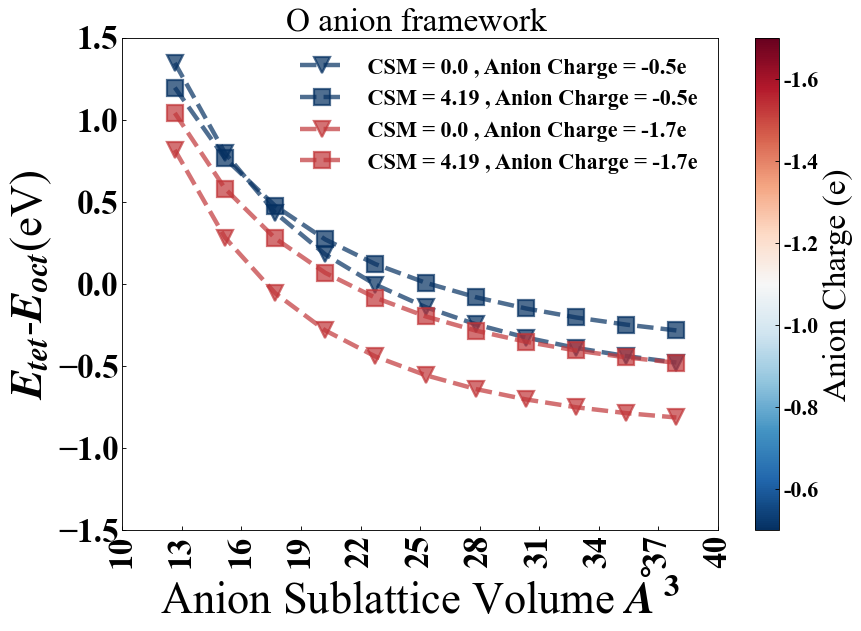

In [92]:
# xstick = volume_per_list
xt = anion_charge_list[elements]
xstick = [0.5,1.7]
type_1 = ''
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
plt.figure(figsize=(12,8),dpi=80)
# plt.xlim((-0.1,3))
# plt.ylim((-0.1,0.5))

a_plt = []
ymax = 0.5
ymin = -0.5
# marker_list =  ['-o', '-v', '-^', '-<','-p']
marker_list1 =  ['-o', '-v', '-^','-<','-p','-s',"->","-P","-*","-H","-+"]
num_plots = len(xt)+2
colormap = plt.cm.RdBu_r
# cmap = mpl.cm.cool
color_array = [colormap(i) for i in np.linspace(0, 1, num_plots)]
# cmap = mpl.cm.cool
# norm = mpl.colors.Normalize(vmin=5, vmax=10)
min, max = (-40, 30)
step = 20
mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['red','blue'])
# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
norm = mpl.colors.Normalize(vmin=xstick[0], vmax=xstick[-1])
# norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu_r)
# cmap.set_array([])
# plt.clf()

vol_list = [0,1,2,3]
a_plt = []
for k in xstick:
#     print(ss.index(k))
    # print(df_tet_oct1)
#     t_plt, = plt.plot(df_tet_oct_list[0].columns.tolist(),df_tet_oct_list[0].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[0]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
    t_plt1, = plt.plot(df_Etet_Eoct_list[1].columns.tolist(),df_Etet_Eoct_list[1].iloc[int(xt.index(k))].tolist(),f'{marker_list1[1]}',
                 c=color_array[xt.index(k)], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt2, = plt.plot(df_tet_oct_list[2].columns.tolist(),df_tet_oct_list[2].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[2]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt3, = plt.plot(df_tet_oct_list[3].columns.tolist(),df_tet_oct_list[3].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[3]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt4, = plt.plot(df_tet_oct_list[4].columns.tolist(),df_tet_oct_list[4].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[4]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
    t_plt5, = plt.plot(df_Etet_Eoct_list[5].columns.tolist(),df_Etet_Eoct_list[5].iloc[int(xt.index(k))].tolist(),f'{marker_list1[5]}',
                 c=color_array[xt.index(k)], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.7,linestyle="--",)
    a_plt.append(t_plt1)
    a_plt.append(t_plt5)
                  # markerfacecolor='none')
  # t_plt1,=plt.plot(df_oct_norm.columns.tolist(),df_oct_norm.iloc[int(xstick.index(k))].tolist(),'-o',c=color_array[xstick.index(k)], markersize=15, linewidth=4,
  #               markeredgewidth=2,alpha=0.7,linestyle="--", )
  #                  markerfacecolor='none')
  # t_plt,=plt.plot(df_delta.columns.tolist(),df_delta.iloc[int(xstick.index(k))].tolist(),'-*',
  #              c=color_array[xstick.index(k)], markersize=15, linewidth=4,
  #               markeredgewidth=2,alpha=0.7,linestyle="--",)
  #                 markerfacecolor='none')
# t_plt2,t_plt3,t_plt4
# a_plt = [t_plt1,t_plt5]
#     a_plt.append(t_plt1)
#     print(a_plt)
# print(marker_list)
# markersize=15, linewidth=4,
#                  markeredgewidth=2
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# print(a_plt)
cbar = plt.colorbar(cmap)
cbar.ax.set_yticklabels([-0.4,-0.6,-0.8,-1.0,-1.2,-1.4,-1.6,-1.8,-2.0])
# cbar.set_label(f'CSM',size=30)
cbar.set_label(f'Anion Charge (e)',size=30)
# cbar.set_label(f'Volume per {elements} Atom($\AA^3$)',size=30)
plt.tick_params(labelsize=30)
plt.xlim(0)
# plt.ylim(-0.05,0.6)
plt.xlabel(f'Anion Sublattice Volume $\AA^3$',fontdict=font1)
plt.ylabel(r'$E_{tet}$-$E_{oct}$(eV)',fontdict=font1)
# plt.ylabel(r'$E_{i}$ (eV)',font1)
# plt.ylabel(r'$E_i^{tet}-E_i^{oct} (eV)$',font1)
new_ticks = np.linspace(xmin[f'{elements}'], xmax[f'{elements}'], 11)
plt.xticks(new_ticks)
form_str='form'
# plt.text(xmin[f'{elements}']-10,ymax,f'({marker_list[index_1]})',fontsize=30)
plt.title(f'{elements} anion framework ',fontsize=30) #图片标题文本和字体大小
plt.yticks(fontproperties = 'Times New Roman', fontsize=30)
plt.xticks(fontproperties = 'Times New Roman', fontsize=30,rotation=90)
print([f' CSM = '+str(round(i,2)) for i in ss2])
l1 = plt.legend(a_plt,[f' CSM = '+str(round(i,2))+' , Anion Charge = '+str(-round(j,2))+'e' for i,j in [(ss2[0],xt[0]),(ss2[-1],xt[0]),(ss2[0],xt[-1]),(ss2[-1],xt[-1])]],loc='best',prop = {'size':20},frameon=False)
# l1 = plt.legend(a_plt,['Tet-Oct'],loc='upper left',prop = {'size':20},frameon=False)
plt.axis([xmin[f'{elements}'],xmax[f'{elements}'],-1.5,1.5])

[' CSM = 0.0', ' CSM = 0.18', ' CSM = 0.72', ' CSM = 1.59', ' CSM = 2.76', ' CSM = 4.19']


/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-v" (-> linestyle='-'). The keyword argument will take precedence.
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


(10.0, 40.0, -1.5, 1.5)

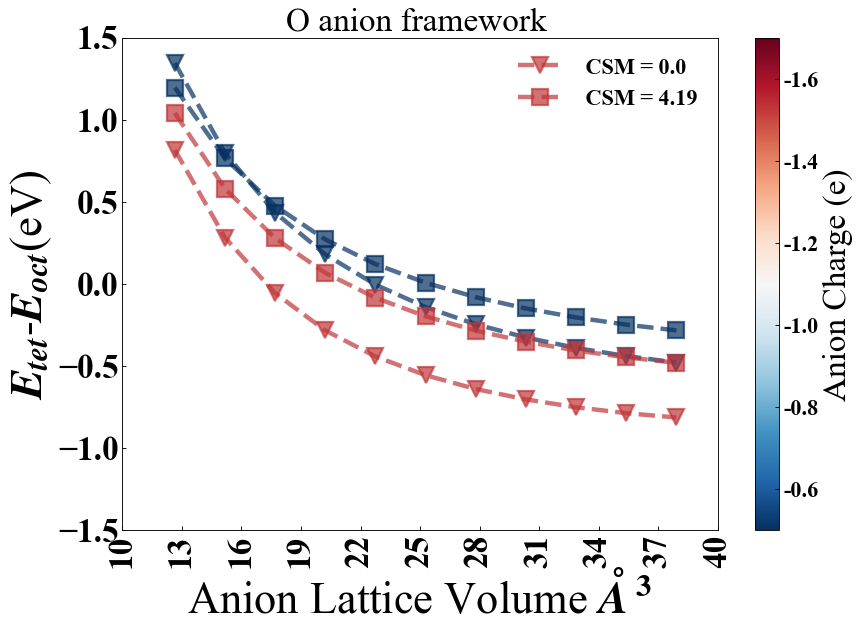

In [93]:
# xstick = volume_per_list
xt = anion_charge_list[elements]
xstick = [0.5,1.7]
type_1 = ''
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
plt.figure(figsize=(12,8),dpi=80)
# plt.xlim((-0.1,3))
# plt.ylim((-0.1,0.5))

a_plt = []
ymax = 0.5
ymin = -0.5
# marker_list =  ['-o', '-v', '-^', '-<','-p']
marker_list1 =  ['-o', '-v', '-^','-<','-p','-s',"->","-P","-*","-H","-+"]
num_plots = len(xt)+2
colormap = plt.cm.RdBu_r
# cmap = mpl.cm.cool
color_array = [colormap(i) for i in np.linspace(0, 1, num_plots)]
# cmap = mpl.cm.cool
# norm = mpl.colors.Normalize(vmin=5, vmax=10)
min, max = (-40, 30)
step = 20
mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['red','blue'])
# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
norm = mpl.colors.Normalize(vmin=xstick[0], vmax=xstick[-1])
# norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu_r)
# cmap.set_array([])
# plt.clf()

vol_list = [0,1,2,3]

for k in xstick:
#     print(ss.index(k))
    # print(df_tet_oct1)
#     t_plt, = plt.plot(df_tet_oct_list[0].columns.tolist(),df_tet_oct_list[0].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[0]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
    t_plt1, = plt.plot(df_Etet_Eoct_list[1].columns.tolist(),df_Etet_Eoct_list[1].iloc[int(xt.index(k))].tolist(),f'{marker_list1[1]}',
                 c=color_array[xt.index(k)], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt2, = plt.plot(df_tet_oct_list[2].columns.tolist(),df_tet_oct_list[2].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[2]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt3, = plt.plot(df_tet_oct_list[3].columns.tolist(),df_tet_oct_list[3].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[3]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt4, = plt.plot(df_tet_oct_list[4].columns.tolist(),df_tet_oct_list[4].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[4]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
    t_plt5, = plt.plot(df_Etet_Eoct_list[5].columns.tolist(),df_Etet_Eoct_list[5].iloc[int(xt.index(k))].tolist(),f'{marker_list1[5]}',
                 c=color_array[xt.index(k)], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.7,linestyle="--",)
                  # markerfacecolor='none')
  # t_plt1,=plt.plot(df_oct_norm.columns.tolist(),df_oct_norm.iloc[int(xstick.index(k))].tolist(),'-o',c=color_array[xstick.index(k)], markersize=15, linewidth=4,
  #               markeredgewidth=2,alpha=0.7,linestyle="--", )
  #                  markerfacecolor='none')
  # t_plt,=plt.plot(df_delta.columns.tolist(),df_delta.iloc[int(xstick.index(k))].tolist(),'-*',
  #              c=color_array[xstick.index(k)], markersize=15, linewidth=4,
  #               markeredgewidth=2,alpha=0.7,linestyle="--",)
  #                 markerfacecolor='none')
# t_plt2,t_plt3,t_plt4
a_plt = [t_plt1,t_plt5]
#     a_plt.append(t_plt1)
#     print(a_plt)
# print(marker_list)
# markersize=15, linewidth=4,
#                  markeredgewidth=2
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# print(a_plt)
cbar = plt.colorbar(cmap)
cbar.ax.set_yticklabels([-0.4,-0.6,-0.8,-1.0,-1.2,-1.4,-1.6,-1.8,-2.0])
# cbar.set_label(f'CSM',size=30)
cbar.set_label(f'Anion Charge (e)',size=30)
# cbar.set_label(f'Volume per {elements} Atom($\AA^3$)',size=30)
plt.tick_params(labelsize=30)
plt.xlim(0)
# plt.ylim(-0.05,0.6)
plt.xlabel(f'Anion Lattice Volume $\AA^3$',fontdict=font1)
plt.ylabel(r'$E_{tet}$-$E_{oct}$(eV)',fontdict=font1)
# plt.ylabel(r'$E_{i}$ (eV)',font1)
# plt.ylabel(r'$E_i^{tet}-E_i^{oct} (eV)$',font1)
new_ticks = np.linspace(xmin[f'{elements}'], xmax[f'{elements}'], 11)
plt.xticks(new_ticks)
form_str='form'
# plt.text(xmin[f'{elements}']-10,ymax,f'({marker_list[index_1]})',fontsize=30)
plt.title(f'{elements} anion framework ',fontsize=30) #图片标题文本和字体大小
plt.yticks(fontproperties = 'Times New Roman', fontsize=30)
plt.xticks(fontproperties = 'Times New Roman', fontsize=30,rotation=90)
print([f'{type_1} CSM = '+str(round(i,2)) for i in ss2])
l1 = plt.legend(a_plt,[f'{type_1} CSM = '+str(round(i,2)) for i in [ss2[0],ss2[-1]]],loc='best',prop = {'size':20},frameon=False)
# l1 = plt.legend(a_plt,['Tet-Oct'],loc='upper left',prop = {'size':20},frameon=False)
plt.axis([xmin[f'{elements}'],xmax[f'{elements}'],-1.5,1.5])